In [1]:
from platform import python_version

print(python_version())

3.7.6


In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [3]:
data = pd.read_csv('UNRATE.csv', header=None)
data.columns=['DATE','UNRATE']
# data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%Y')
data = data.set_index('DATE')

In [4]:
data.head()

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [5]:
data.isnull().any()

UNRATE    False
dtype: bool

 The overall data you have is for 867 months. Divide this data into train data (first 612 months) and test data (last 255 months)

- Perform the Box-Cox transformation (with lmbda = 0) and one lag differencing to get a stationary series.
- Forecast the number for the unemployment rate on the test data Using AR and MA method of forecasting.

In [6]:
data['UNRATE'].isnull().sum()

0

In [7]:
# Train Test Split
train_len = 612
train = data[0:train_len]
test = data[train_len:]

In [8]:
print(train.shape)
print(test.shape)

(612, 1)
(255, 1)


In [9]:
train.tail()

,UNRATE
DATE,
1998-08-01,4.5
1998-09-01,4.6
1998-10-01,4.5
1998-11-01,4.4
1998-12-01,4.4


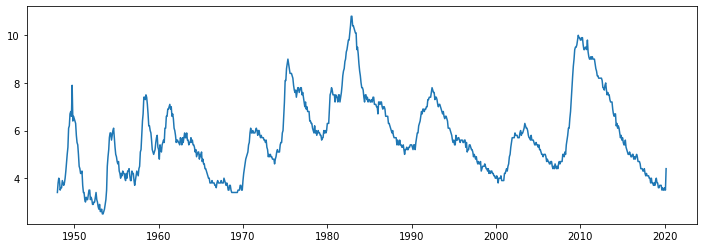

In [10]:
plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

# Boxcox Transformation

In [11]:
# library
from scipy.stats import boxcox

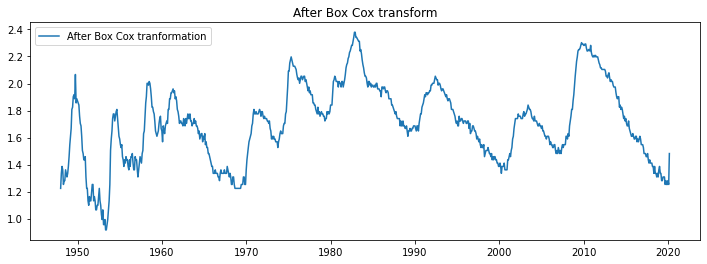

In [12]:
data_boxcox = pd.Series(boxcox(data['UNRATE'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

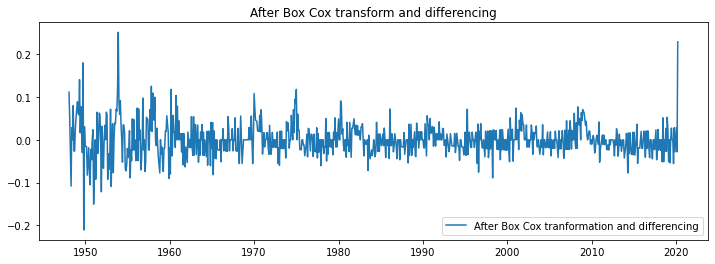

In [13]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

#### Forecast the number for the unemployment rate on the test data Using AR and MA method of forecasting

In [14]:
data_boxcox_diff.shape

(867,)

In [15]:
data_boxcox_diff.dropna(inplace=True)

In [16]:
data_boxcox_diff.shape

(866,)

## Train Test Split

In [17]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [18]:
data_boxcox_diff.shape

(866,)

In [19]:
print(train_data_boxcox.shape)
print(test_data_boxcox.shape)
print(train_data_boxcox_diff.shape)
print(test_data_boxcox_diff.shape)

(612,)
(255,)
(611,)
(255,)


In [20]:
# AR Model
from statsmodels.tsa.arima_model import ARIMA

- RMSE and MAPE
- What are the RMSE and MAPE values for the AR(12) process?

In [21]:
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090455
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047124
ar.L12.y   -0.148533
dtype: float64


In [22]:
# Recovery the original series

y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [23]:
y_hat_ar['ar_forecast'].head(12)

1948-02-01    3.401586
1948-03-01    3.453112
1948-04-01    3.559367
1948-05-01    3.651090
1948-06-01    3.670434
1948-07-01    3.643279
1948-08-01    3.619416
1948-09-01    3.579693
1948-10-01    3.585961
1948-11-01    3.613181
1948-12-01    3.569608
1949-01-01    3.587689
Freq: MS, dtype: float64

In [24]:
y_hat_ar.tail()

DATE
2020-02-01 00:00:00                                               -0.0281709
2020-03-01 00:00:00                                                 0.228842
ar_forecast_boxcox_diff    1948-02-01    0.000466
1948-03-01    0.015034
...
ar_forecast_boxcox         1948-02-01    1.224242
1948-03-01    1.239276
...
ar_forecast                1948-02-01    3.401586
1948-03-01    3.453112
...
dtype: object

In [25]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_ar['ar_forecast'][test.index.min():])/test['UNRATE'])*100,2)

print(rmse, mape)
results = pd.DataFrame({'Method': ['AR'], 'RMSE':[rmse], 'MAPE':[mape]})
results

2.07 21.5


,Method,RMSE,MAPE
0,AR,2.07,21.5


# MA(5) model

In [26]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [27]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ma_forecast_boxcox'] = y_hat_ar['ma_forecast_boxcox_diff'].cumsum()
y_hat_ar['ma_forecast_boxcox'] = y_hat_ar['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ma_forecast'] = np.exp(y_hat_ar['ma_forecast_boxcox'])

In [28]:
y_hat_ar['ma_forecast']

1948-02-01    3.401726
1948-03-01    3.443834
1948-04-01    3.537628
1948-05-01    3.611959
1948-06-01    3.610562
                ...   
2019-11-01    5.162574
2019-12-01    5.165194
2020-01-01    5.167816
2020-02-01    5.170439
2020-03-01    5.173063
Freq: MS, Length: 866, dtype: float64